## Imports

In [4]:
# !pip install langchain 
# !pip install openai
# !pip install dotenv

In [5]:
import openai
from packaging import version

In [6]:
required_version = version.parse("1.2.0")
current_version = version.parse(openai.__version__)

if current_version < required_version:
    raise ValueError(f"Error: OpenAI version {openai.__version__}"
                     " is less than the required version 1.2.0")
else:
    print("OpenAI version is compatible.")

OpenAI version is compatible.


In [19]:
from openai import OpenAI
import json
import os
from dotenv import load_dotenv
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np 

In [8]:
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000)  
pd.set_option('display.max_colwidth', None)


In [9]:
# Load environment variables from a .env file
load_dotenv()

# Attempt to retrieve the OPENAI_API_KEY environment variable
api_key = os.getenv("OPENAI_API_KEY")

if api_key is None:
    raise ValueError("Your .env file doesn't contain an OPENAI_API_KEY.")

# Retreive OpenAI API key
OpenAI.api_key = api_key

In [5]:
# Create OpenAI client
client = OpenAI()

In [6]:
bias_function = [{
    "name": "bias_classification",
    "description": "Identify the bias of the given sentence.",
    "parameters": {
        "type": "object",
        "properties": {
            "bias_classification": {  
                "type": "string",
                "enum": [ 
                    "Linguistic Bias",
                    "Gender Bias",
                    "Racial Bias",
                    "Hate Speech",
                    "Political Bias",
                    "Fake News",
                ],
                "description": "The category of bias identified."
            }
        },
        "required": ["bias_classification"] 
    }
}]

In [7]:
def get_bias_prediction(sentence, client=client, bias_function=bias_function):

    response = client.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {
                "role": "system",
                "content": "You are a bias detection assistant. Make sure to assess negative bias. Do not assess words in quotes. Do not assess names of individuals. Follow the AP Style Guidebook. You must select an option."
            },
            {
                "role": "user",
                "content": f"What is the bias classification of the sentence: '{sentence}'"
            }
        ],
        temperature=0,
        # max_tokens = 200,
        functions=bias_function,
        function_call="auto",
    )

    return response.choices[0].message.function_call

In [8]:
df = pd.read_csv('balanced_df_gpt.csv')

In [9]:
print(df.head(20))

    index                                              input           output   
0       0   They Clinton and Obama have never to my knowl...        Fake News  \
1       1  I cannot stand the fact that I must purchase f...   Political Bias   
2       2  initially i was like oh woah your sister is pu...      Hate Speech   
3       3           can confirm wife is an attractive nurse       Hate Speech   
4       4  in the real world variags is another name for ...  Linguistic Bias   
5       5  how goes the crazyhot cuz my girl is hot borde...      Racial Bias   
6       6  German Airbus A320 Plane Crashes 148 People DE...        Fake News   
7       7   Gays on juries Federal appeals court forbids ...  Linguistic Bias   
8       8  it would probably be awesome my grandmother is...      Gender Bias   
9       9   Took crockery furniture artwork and other ite...   Political Bias   
10     10  i just posted the gospel passage that explains...      Racial Bias   
11     11   In just one mont

In [10]:
len(df)

6000

In [17]:
test_df = df.head(20)

In [18]:
len(test_df)

20

In [19]:
print(test_df)

    index                                              input           output   
0       0   They Clinton and Obama have never to my knowl...        Fake News  \
1       1  I cannot stand the fact that I must purchase f...   Political Bias   
2       2  initially i was like oh woah your sister is pu...      Hate Speech   
3       3           can confirm wife is an attractive nurse       Hate Speech   
4       4  in the real world variags is another name for ...  Linguistic Bias   
5       5  how goes the crazyhot cuz my girl is hot borde...      Racial Bias   
6       6  German Airbus A320 Plane Crashes 148 People DE...        Fake News   
7       7   Gays on juries Federal appeals court forbids ...  Linguistic Bias   
8       8  it would probably be awesome my grandmother is...      Gender Bias   
9       9   Took crockery furniture artwork and other ite...   Political Bias   
10     10  i just posted the gospel passage that explains...      Racial Bias   
11     11   In just one mont

## Evaluation

In [40]:
def apply_prediction(row, max_retries=1):
    retries = 0
    while retries < max_retries:
        try:
            response = get_bias_prediction(row['input'])
            response_loaded = json.loads(response.arguments)
            bias_classification = response_loaded.get('bias_classification')
            if bias_classification is not None:
                return bias_classification
            retries += 1
        except Exception as exc:
            print(f"Error processing row {row['index']}: {exc}")
            retries += 1
    return "Error"

In [64]:
def add_predictions(df):
    with ThreadPoolExecutor(max_workers=5) as executor:
        # Adjusted to include client and bias_function in the submission
        future_to_row = {executor.submit(apply_prediction, row): i for i, row in df.iterrows()}

        # Progress bar setup
        progress = tqdm(as_completed(future_to_row), total=len(df), desc="Processing", unit="row")

        for future in progress:
            row_index = future_to_row[future]
            try:
                prediction_result = future.result()
                df.at[row_index, 'gpt4turbo_eval'] = prediction_result
            except Exception as exc:
                print(f'Row {row_index} generated an exception: {exc}')
                df.at[row_index, 'gpt4turbo_eval'] = 'Error'

    return df

In [65]:
gpt_eval_df = add_predictions(df)

Processing:   1%|▏         | 77/6000 [00:14<19:44,  5.00row/s] 

Error processing row 73: 'NoneType' object has no attribute 'arguments'


Processing:   2%|▏         | 110/6000 [00:20<16:28,  5.96row/s]

Error processing row 106: 'NoneType' object has no attribute 'arguments'


Processing:   3%|▎         | 179/6000 [00:34<16:59,  5.71row/s]

Error processing row 175: 'NoneType' object has no attribute 'arguments'


Processing:   3%|▎         | 205/6000 [00:40<22:53,  4.22row/s]

Error processing row 202: 'NoneType' object has no attribute 'arguments'


Processing:   3%|▎         | 207/6000 [00:40<19:14,  5.02row/s]

Error processing row 205: 'NoneType' object has no attribute 'arguments'


Processing:   4%|▎         | 217/6000 [00:42<18:18,  5.27row/s]

Error processing row 214: 'NoneType' object has no attribute 'arguments'


Processing:   4%|▍         | 225/6000 [00:43<19:54,  4.83row/s]

Error processing row 223: 'NoneType' object has no attribute 'arguments'


Processing:   5%|▌         | 311/6000 [01:00<17:43,  5.35row/s]

Error processing row 306: 'NoneType' object has no attribute 'arguments'


Processing:   5%|▌         | 318/6000 [01:03<23:54,  3.96row/s]

Error processing row 316: 'NoneType' object has no attribute 'arguments'
Error processing row 318: 'NoneType' object has no attribute 'arguments'


Processing:   6%|▌         | 338/6000 [01:06<14:54,  6.33row/s]

Error processing row 332: 'NoneType' object has no attribute 'arguments'


Processing:   6%|▌         | 339/6000 [01:07<19:49,  4.76row/s]

Error processing row 338: 'NoneType' object has no attribute 'arguments'


Processing:   6%|▋         | 382/6000 [01:14<17:30,  5.35row/s]

Error processing row 378: 'NoneType' object has no attribute 'arguments'


Processing:   7%|▋         | 397/6000 [01:17<20:58,  4.45row/s]

Error processing row 395: 'NoneType' object has no attribute 'arguments'


Processing:   9%|▉         | 546/6000 [01:44<16:58,  5.36row/s]

Error processing row 543: 'NoneType' object has no attribute 'arguments'


Processing:  10%|▉         | 583/6000 [01:51<16:34,  5.45row/s]

Error processing row 580: 'NoneType' object has no attribute 'arguments'


Processing:  10%|█         | 630/6000 [02:00<13:58,  6.41row/s]

Error processing row 627: 'NoneType' object has no attribute 'arguments'


Processing:  12%|█▏        | 701/6000 [02:13<17:10,  5.14row/s]

Error processing row 696: 'NoneType' object has no attribute 'arguments'


Processing:  12%|█▏        | 734/6000 [02:20<16:55,  5.19row/s]

Error processing row 729: 'NoneType' object has no attribute 'arguments'


Processing:  13%|█▎        | 766/6000 [02:26<14:43,  5.92row/s]

Error processing row 761: 'NoneType' object has no attribute 'arguments'


Processing:  14%|█▍        | 839/6000 [02:39<14:24,  5.97row/s]

Error processing row 834: 'NoneType' object has no attribute 'arguments'


Processing:  15%|█▌        | 927/6000 [02:56<16:09,  5.23row/s]

Error processing row 923: 'NoneType' object has no attribute 'arguments'


Processing:  17%|█▋        | 1001/6000 [03:10<24:12,  3.44row/s]

Error processing row 1000: 'NoneType' object has no attribute 'arguments'


Processing:  17%|█▋        | 1025/6000 [03:15<17:23,  4.77row/s]

Error processing row 1022: 'NoneType' object has no attribute 'arguments'


Processing:  17%|█▋        | 1047/6000 [03:19<13:36,  6.06row/s]

Error processing row 1042: 'NoneType' object has no attribute 'arguments'


Processing:  19%|█▊        | 1119/6000 [03:32<13:55,  5.84row/s]

Error processing row 1114: 'NoneType' object has no attribute 'arguments'


Processing:  20%|██        | 1214/6000 [03:50<15:27,  5.16row/s]

Error processing row 1207: 'NoneType' object has no attribute 'arguments'


Processing:  22%|██▏       | 1292/6000 [04:05<20:30,  3.83row/s]

Error processing row 1289: 'NoneType' object has no attribute 'arguments'


Processing:  23%|██▎       | 1368/6000 [04:19<17:05,  4.52row/s]

Error processing row 1366: 'NoneType' object has no attribute 'arguments'


Processing:  23%|██▎       | 1377/6000 [04:21<12:14,  6.29row/s]

Error processing row 1372: 'NoneType' object has no attribute 'arguments'


Processing:  24%|██▎       | 1410/6000 [04:27<14:59,  5.10row/s]

Error processing row 1408: 'NoneType' object has no attribute 'arguments'


Processing:  24%|██▎       | 1411/6000 [04:27<13:11,  5.79row/s]

Error processing row 1406: 'NoneType' object has no attribute 'arguments'


Processing:  28%|██▊       | 1700/6000 [05:23<16:38,  4.31row/s]

Error processing row 1696: 'NoneType' object has no attribute 'arguments'


Processing:  30%|██▉       | 1770/6000 [05:36<17:48,  3.96row/s]

Error processing row 1769: 'NoneType' object has no attribute 'arguments'


Processing:  30%|███       | 1800/6000 [05:43<16:22,  4.28row/s]

Error processing row 1799: 'NoneType' object has no attribute 'arguments'


Processing:  31%|███       | 1848/6000 [05:52<13:04,  5.29row/s]

Error processing row 1845: 'NoneType' object has no attribute 'arguments'


Processing:  32%|███▏      | 1937/6000 [06:10<16:14,  4.17row/s]

Error processing row 1934: 'NoneType' object has no attribute 'arguments'


Processing:  33%|███▎      | 1956/6000 [06:15<14:48,  4.55row/s]

Error processing row 1952: 'NoneType' object has no attribute 'arguments'


Processing:  33%|███▎      | 1994/6000 [06:23<14:05,  4.74row/s]

Error processing row 1932: 'NoneType' object has no attribute 'arguments'


Processing:  33%|███▎      | 2006/6000 [06:25<12:21,  5.39row/s]

Error processing row 2002: 'NoneType' object has no attribute 'arguments'


Processing:  36%|███▌      | 2160/6000 [06:59<13:24,  4.77row/s]

Error processing row 2155: 'NoneType' object has no attribute 'arguments'


Processing:  38%|███▊      | 2285/6000 [07:26<10:14,  6.04row/s]

Error processing row 2281: 'NoneType' object has no attribute 'arguments'


Processing:  40%|████      | 2421/6000 [07:52<16:07,  3.70row/s]

Error processing row 2420: 'NoneType' object has no attribute 'arguments'
Error processing row 2419: 'NoneType' object has no attribute 'arguments'


Processing:  41%|████▏     | 2475/6000 [08:04<09:11,  6.40row/s]

Error processing row 2470: 'NoneType' object has no attribute 'arguments'


Processing:  43%|████▎     | 2566/6000 [08:25<10:59,  5.21row/s]

Error processing row 2563: 'NoneType' object has no attribute 'arguments'


Processing:  43%|████▎     | 2572/6000 [08:26<12:54,  4.42row/s]

Error processing row 2570: 'NoneType' object has no attribute 'arguments'


Processing:  44%|████▍     | 2648/6000 [08:40<09:41,  5.76row/s]

Error processing row 2645: 'NoneType' object has no attribute 'arguments'


Processing:  45%|████▍     | 2690/6000 [08:48<10:27,  5.27row/s]

Error processing row 2687: 'NoneType' object has no attribute 'arguments'


Processing:  45%|████▌     | 2702/6000 [08:52<16:31,  3.32row/s]

Error processing row 2700: 'NoneType' object has no attribute 'arguments'


Processing:  45%|████▌     | 2705/6000 [08:52<11:43,  4.69row/s]

Error processing row 2703: 'NoneType' object has no attribute 'arguments'


Processing:  48%|████▊     | 2850/6000 [09:22<09:03,  5.79row/s]

Error processing row 2842: 'NoneType' object has no attribute 'arguments'


Processing:  48%|████▊     | 2861/6000 [09:24<10:56,  4.78row/s]

Error processing row 2858: 'NoneType' object has no attribute 'arguments'


Processing:  49%|████▊     | 2923/6000 [09:35<09:18,  5.51row/s]

Error processing row 2919: 'NoneType' object has no attribute 'arguments'


Processing:  49%|████▉     | 2934/6000 [09:38<09:13,  5.54row/s]

Error processing row 2932: 'NoneType' object has no attribute 'arguments'


Processing:  52%|█████▏    | 3120/6000 [10:16<08:39,  5.54row/s]

Error processing row 3117: 'NoneType' object has no attribute 'arguments'


Processing:  52%|█████▏    | 3149/6000 [10:22<09:32,  4.98row/s]

Error processing row 3146: 'NoneType' object has no attribute 'arguments'


Processing:  59%|█████▊    | 3512/6000 [11:36<06:53,  6.02row/s]

Error processing row 3508: 'NoneType' object has no attribute 'arguments'


Processing:  59%|█████▊    | 3522/6000 [11:38<08:35,  4.81row/s]

Error processing row 3517: 'NoneType' object has no attribute 'arguments'


Processing:  59%|█████▉    | 3541/6000 [11:42<09:26,  4.34row/s]

Error processing row 3540: 'NoneType' object has no attribute 'arguments'


Processing:  59%|█████▉    | 3553/6000 [11:44<06:40,  6.11row/s]

Error processing row 3549: 'NoneType' object has no attribute 'arguments'


Processing:  64%|██████▍   | 3859/6000 [12:41<06:47,  5.25row/s]

Error processing row 3857: 'NoneType' object has no attribute 'arguments'


Processing:  65%|██████▍   | 3895/6000 [12:47<06:01,  5.82row/s]

Error processing row 3890: 'NoneType' object has no attribute 'arguments'


Processing:  66%|██████▌   | 3941/6000 [12:56<05:39,  6.06row/s]

Error processing row 3935: 'NoneType' object has no attribute 'arguments'


Processing:  67%|██████▋   | 4001/6000 [13:10<09:59,  3.33row/s]

Error processing row 3988: 'NoneType' object has no attribute 'arguments'


Processing:  67%|██████▋   | 4030/6000 [13:15<05:06,  6.44row/s]

Error processing row 4026: 'NoneType' object has no attribute 'arguments'


Processing:  68%|██████▊   | 4077/6000 [13:24<05:15,  6.10row/s]

Error processing row 4072: 'NoneType' object has no attribute 'arguments'


Processing:  68%|██████▊   | 4086/6000 [13:26<05:16,  6.04row/s]

Error processing row 4082: 'NoneType' object has no attribute 'arguments'


Processing:  69%|██████▊   | 4120/6000 [13:32<05:57,  5.26row/s]

Error processing row 4115: 'NoneType' object has no attribute 'arguments'


Processing:  70%|██████▉   | 4171/6000 [13:42<07:54,  3.85row/s]

Error processing row 4170: 'NoneType' object has no attribute 'arguments'


Processing:  70%|██████▉   | 4184/6000 [13:45<07:41,  3.93row/s]

Error processing row 4184: 'NoneType' object has no attribute 'arguments'


Processing:  72%|███████▏  | 4308/6000 [14:14<05:49,  4.84row/s]

Error processing row 4305: 'NoneType' object has no attribute 'arguments'


Processing:  72%|███████▏  | 4341/6000 [14:21<05:29,  5.03row/s]

Error processing row 4334: 'NoneType' object has no attribute 'arguments'


Processing:  75%|███████▌  | 4506/6000 [14:53<04:52,  5.11row/s]

Error processing row 4498: Unterminated string starting at: line 1 column 24 (char 23)


Processing:  76%|███████▌  | 4533/6000 [14:58<05:08,  4.75row/s]

Error processing row 4531: 'NoneType' object has no attribute 'arguments'


Processing:  76%|███████▌  | 4543/6000 [15:00<05:16,  4.60row/s]

Error processing row 4538: 'NoneType' object has no attribute 'arguments'


Processing:  77%|███████▋  | 4643/6000 [15:21<04:50,  4.68row/s]

Error processing row 4638: 'NoneType' object has no attribute 'arguments'


Processing:  80%|███████▉  | 4774/6000 [15:48<03:47,  5.39row/s]

Error processing row 4771: 'NoneType' object has no attribute 'arguments'
Error processing row 4768: 'NoneType' object has no attribute 'arguments'


Processing:  83%|████████▎ | 4956/6000 [16:28<04:44,  3.67row/s]

Error processing row 4954: 'NoneType' object has no attribute 'arguments'


Processing:  83%|████████▎ | 4959/6000 [16:28<03:11,  5.44row/s]

Error processing row 4956: 'NoneType' object has no attribute 'arguments'


Processing:  87%|████████▋ | 5240/6000 [17:24<02:51,  4.42row/s]

Error processing row 5237: 'NoneType' object has no attribute 'arguments'


Processing:  88%|████████▊ | 5250/6000 [17:26<02:07,  5.87row/s]

Error processing row 5246: 'NoneType' object has no attribute 'arguments'


Processing:  88%|████████▊ | 5296/6000 [17:37<03:24,  3.44row/s]

Error processing row 5294: 'NoneType' object has no attribute 'arguments'


Processing:  91%|█████████ | 5466/6000 [18:13<01:28,  6.02row/s]

Error processing row 5462: 'NoneType' object has no attribute 'arguments'
Error processing row 5455: 'NoneType' object has no attribute 'arguments'


Processing:  92%|█████████▏| 5505/6000 [18:21<02:07,  3.88row/s]

Error processing row 5504: 'NoneType' object has no attribute 'arguments'


Processing:  92%|█████████▏| 5548/6000 [18:29<01:19,  5.69row/s]

Error processing row 5546: 'NoneType' object has no attribute 'arguments'


Processing:  93%|█████████▎| 5561/6000 [18:31<01:11,  6.15row/s]

Error processing row 5556: 'NoneType' object has no attribute 'arguments'


Processing:  93%|█████████▎| 5587/6000 [18:37<01:34,  4.36row/s]

Error processing row 5581: Unterminated string starting at: line 1 column 24 (char 23)


Processing:  93%|█████████▎| 5600/6000 [18:39<01:19,  5.05row/s]

Error processing row 5595: 'NoneType' object has no attribute 'arguments'


Processing:  94%|█████████▍| 5656/6000 [18:53<01:09,  4.98row/s]

Error processing row 5653: 'NoneType' object has no attribute 'arguments'
Error processing row 5654: 'NoneType' object has no attribute 'arguments'


Processing:  95%|█████████▍| 5695/6000 [19:01<00:48,  6.28row/s]

Error processing row 5691: 'NoneType' object has no attribute 'arguments'


Processing:  96%|█████████▌| 5763/6000 [19:16<00:43,  5.51row/s]

Error processing row 5760: 'NoneType' object has no attribute 'arguments'


Processing:  96%|█████████▌| 5773/6000 [19:18<00:47,  4.80row/s]

Error processing row 5771: 'NoneType' object has no attribute 'arguments'


Processing:  97%|█████████▋| 5791/6000 [19:22<00:50,  4.15row/s]

Error processing row 5788: 'NoneType' object has no attribute 'arguments'


Processing:  98%|█████████▊| 5850/6000 [19:33<00:38,  3.87row/s]

Error processing row 5845: 'NoneType' object has no attribute 'arguments'


Processing:  98%|█████████▊| 5854/6000 [19:34<00:37,  3.94row/s]

Error processing row 5853: 'NoneType' object has no attribute 'arguments'


Processing:  98%|█████████▊| 5889/6000 [19:41<00:19,  5.63row/s]

Error processing row 5884: 'NoneType' object has no attribute 'arguments'


Processing:  98%|█████████▊| 5909/6000 [19:45<00:17,  5.30row/s]

Error processing row 5903: 'NoneType' object has no attribute 'arguments'


Processing: 100%|█████████▉| 5995/6000 [20:02<00:01,  4.88row/s]

Error processing row 5991: 'NoneType' object has no attribute 'arguments'


Processing: 100%|██████████| 6000/6000 [20:03<00:00,  4.99row/s]


In [88]:
gpt_eval_df.to_csv('balance_df_gpt_eval.csv', index=False)

## Confusion Matrix

In [10]:
gpt_eval_df = pd.read_csv('balance_df_gpt_eval.csv')

In [11]:
labels=["Fake News", "Political Bias", "Hate Speech", "Linguistic Bias", "Gender Bias", "Racial Bias"]

# Filter the DataFrame to include only valid labels
valid_df = gpt_eval_df[(gpt_eval_df['output'].isin(labels)) & (gpt_eval_df['gpt4turbo_eval'].isin(labels))]

# Define y_true and y_pred from the filtered DataFrame
y_true = valid_df['output']
y_pred = valid_df['gpt4turbo_eval']

In [12]:
len(y_true)

5854

In [13]:
len(y_pred)

5854

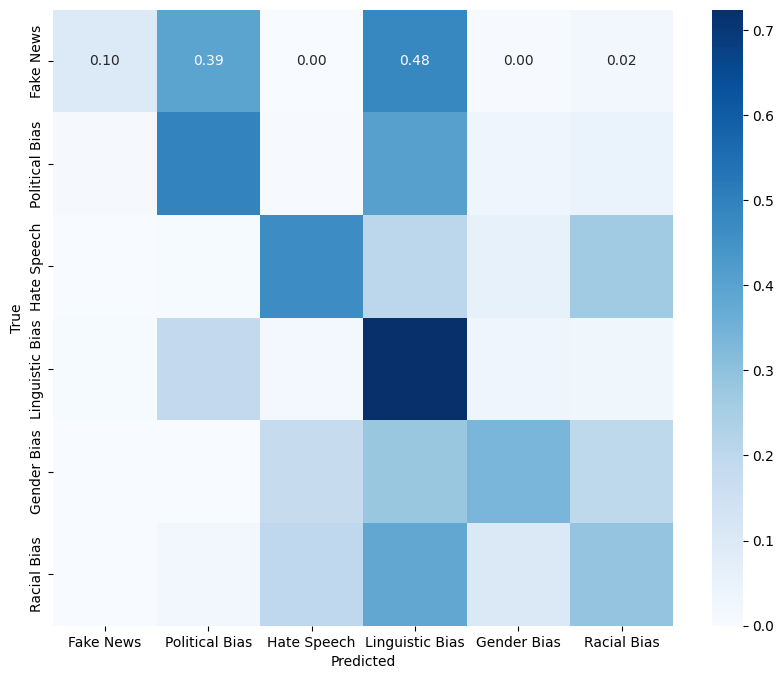

In [20]:
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
